# EAI Hot Topics class Homework 3: Visual WSD
###Ludovico Comito Matr. 1837155

## GDrive and imports

In [ ]:
!pip install transformers

In [ ]:
from transformers import CLIPProcessor, CLIPModel, CLIPSegModel, AutoProcessor, AutoTokenizer, AutoModel, pipeline

import torch
import torch.nn as nn
import torch.optim as optim


import pandas as pd
from PIL import Image
import re
import numpy as np
import os
import json
import random
from tqdm import tqdm
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
parameters_dict = {
    'test_dir':'/content/drive/MyDrive/hot_topics_nlp/homework_3/dataset/test_v1',
    'test_img_dir':'/content/drive/MyDrive/hot_topics_nlp/homework_3/dataset/test_v1/test_images_resized',
    'predictions_files_dir':'/content/drive/MyDrive/hot_topics_nlp/homework_3/predictions_files', # where to store model's predictions
    'language':'en', # en, it, fa
    'model_name':'CIDAS/clipseg-rd64-refined', # [openai/clip-vit-base-patch32, "CIDAS/clipseg-rd64-refined"]
}

In [ ]:
# set device
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

## Dataloading

In [ ]:
def extract_number(filename):
    match = re.search(r'(\d+)', filename)
    return int(match.group(0)) if match else None

def parse_file_to_dataframe(filepath, img_dir):
    '''
    Given the data file and image directory, parse the data into a dataframe and reuturn the context, candidate word,
    candidate images and labels.
    '''
    # Initialize lists to store the data
    candidate_words = []
    contexts = []
    candidate_images = []
    candidate_indices = []

    # Open and read the file
    with open(filepath, 'r') as file:
        for line in file:
            # Split the line into parts
            parts = line.strip().split('\t')

            # Extract candidate_word and context
            candidate_word, context = parts[0], parts[1]

            # Extract candidate_images (remaining parts)
            images = parts[2:]
            for i in range(len(images)):
              images[i] = img_dir + '/' + images[i]

            # Split both candidate_word and context into words
            candidate_word_parts = candidate_word.split()
            context_parts = context.split()

            # Find the indices of each word of the candidate in the context
            indices = []
            for word in candidate_word_parts:
                try:
                    index = context_parts.index(word)
                    indices.append(index)
                except ValueError:
                    indices.append(-1)  # Word not found

            # Append to the respective lists
            candidate_words.append(candidate_word)
            contexts.append(context)
            candidate_images.append(images)
            candidate_indices.append(indices)

    # Create a DataFrame
    df = pd.DataFrame({
        'candidate_word': candidate_words,
        'context': contexts,
        'candidate_images': candidate_images,
        'candidate_index': candidate_indices,
    })

    return df



def parse_labels(filepath, img_dir):
  labels = []

  # Open and read the file
  with open(filepath, 'r') as file:
      for line in file:
          # Split the line into parts
          label = img_dir + '/' + line.strip()
          labels.append(label)
  return labels


In [ ]:
# parse files based on the test dataset language.
if parameters_dict['language']=='it':
  parsed_input = parse_file_to_dataframe(parameters_dict['test_dir']+'/it.test.data.v1.1.txt', parameters_dict['test_img_dir'])
  labels = parse_labels(parameters_dict['test_dir']+'/it.test.gold.v1.1.txt', parameters_dict['test_img_dir'])
elif parameters_dict['language']=='en':
  parsed_input = parse_file_to_dataframe(parameters_dict['test_dir']+'/en.test.data.v1.1.txt', parameters_dict['test_img_dir'])
  labels = parse_labels(parameters_dict['test_dir']+'/en.test.gold.v1.1.txt', parameters_dict['test_img_dir'])
else:
  parsed_input = parse_file_to_dataframe(parameters_dict['test_dir']+'/fa.test.data.txt', parameters_dict['test_img_dir'])
  labels = parse_labels(parameters_dict['test_dir']+'/fa.test.gold.txt', parameters_dict['test_img_dir'])

In [ ]:
def index_labels(parsed_input, labels):
  # Find the index of the label inside the candidate images list
  target_index = []
  candidates_list = parsed_input['candidate_images']
  for i in range(len(candidates_list)):
    candidates = candidates_list[i]
    for index, string in enumerate(candidates):
      if string == labels[i]:
        target_index.append(index)
  return target_index

In [ ]:
# Transform golden image paths into numeric labels
indexed_labels = index_labels(parsed_input, labels)

## Load the model

In this work, CLIP and CLIPSeg are tested.

In [ ]:
if parameters_dict['model_name'] == 'openai/clip-vit-base-patch32':
  model = CLIPModel.from_pretrained(parameters_dict['model_name']).to(device)
  processor = CLIPProcessor.from_pretrained(parameters_dict['model_name'], padding="max_length", truncation=True)
elif parameters_dict['model_name'] == 'CIDAS/clipseg-rd64-refined':
  processor = AutoProcessor.from_pretrained(parameters_dict['model_name'])
  model = CLIPSegModel.from_pretrained(parameters_dict['model_name']).to(device)
else:
  raise Exception("Check model name")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/974 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/603M [00:00<?, ?B/s]

## Test the model on the english dataset (no translation)

In [ ]:
def load_images(candidate_images):
  '''
  Load the images corresponding to the given samples using th PIL library.
  '''
  loaded_images = []
  for candidate in candidate_images:
    image = Image.open(candidate)
    if image.mode != "RGB":
      image = image.convert("RGB")
    loaded_images.append(image)
  return loaded_images

During the test phase, for each sample are parsed the context, candidate word (the word to disambiguate), the candidate images for that sample and the correspoding label. After preprocessing, the text-image similarities are extracted. Logits are then transormed to probabilities using a Softmax, and finally the prediction will correspond to the argmax of those logits. This loop is suitable for both CLIP and CLIPSeg.

In [ ]:
correct_predictions = 0
correct_images = []
for i in range(len(parsed_input)):
  current_context = parsed_input['context'][i] # using the context
  current_ambiguity = parsed_input['candidate_word'][i]
  current_img_candidates = parsed_input['candidate_images'][i]
  current_label = indexed_labels[i]

  loaded_images = load_images(current_img_candidates)

  model_input = processor(text=[current_context], images=loaded_images, return_tensors='pt').to(device)
  output = model(**model_input)
  text_logits = output.logits_per_text #similarities
  probs = text_logits.softmax(dim=1)
  prediction = torch.argmax(probs)

  if prediction.item() == current_label:
    print(f'Predicted correctly sample {i}, context: {current_context}, candidate_word: {current_ambiguity}')
    correct_predictions += 1
    image_name = current_img_candidates[current_label].split('/')[-1] # recover image name ex: 'image.4418.jpg'
    correct_images.append(image_name)

# print accuracy results
accuracy = correct_predictions/len(parsed_input)
print('Candidate word vs images result')
print(f'Total_accuracy: {accuracy*100}%, correct_predictions: {correct_predictions}')

Save predictions

In [ ]:
def create_predictions_file(file_path, correct_images):
  # Open the file in write mode and write each string in the list to a new line
  with open(file_path, 'w') as file:
      for string in correct_images:
          file.write(string + '\n')

In [ ]:
prediction_name = 'en.test.preds.txt'
file_path = parameters_dict['predictions_files_dir'] + prediction_name
create_predictions_file(file_path, correct_images)

## Test the model on Italian and Farsi
In the Italian and Farsi case, texts are translated before being fed to the model.

In [ ]:
if parameters_dict['language'] == 'it':
  pipe = pipeline("text2text-generation", model="Helsinki-NLP/opus-mt-it-en")
else:
  pipe = pipeline("text2text-generation", model="persiannlp/mt5-base-parsinlu-opus-translation_fa_en")

config.json:   0%|          | 0.00/696 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/375 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
correct_predictions = 0
correct_images = []
for i in range(len(parsed_input)):
  current_context = parsed_input['context'][i] # using the context
  current_ambiguity = parsed_input['candidate_word'][i]
  current_img_candidates = parsed_input['candidate_images'][i]
  current_label = indexed_labels[i]

  loaded_images = load_images(current_img_candidates)
  translated_context = pipe(current_context)[0]['generated_text']
  model_input = processor(text=[translated_context], images=loaded_images, return_tensors='pt', truncation=True).to(device)
  output = model(**model_input)
  text_logits = output.logits_per_text
  probs = text_logits.softmax(dim=1)
  prediction = torch.argmax(probs)

  if prediction.item() == current_label:
    print(f'Predicted correctly sample {i}, context: {current_context}, translation: {translated_context}, candidate_word: {current_ambiguity}')
    correct_predictions += 1
    image_name = current_img_candidates[current_label].split('/')[-1] # recover image name ex: 'image.4418.jpg'
    correct_images.append(image_name)

# print accuracy results
accuracy = correct_predictions/len(parsed_input)
print('Candidate word vs images result')
print(f'Total_accuracy: {accuracy*100}%, correct_predictions: {correct_predictions}')

In [ ]:
if parameters_dict['language'] == 'it':
  prediction_name = 'it.test.preds.txt'
elif parameters_dict['language'] == 'fa':
  prediction_name = 'fa.test.preds.txt'
file_path = parameters_dict['predictions_files_dir'] + prediction_name
create_predictions_file(file_path, correct_images)

## Qualitative analysis

### Investigating saliency maps
Saliency maps allow us to interpret which regions of the input image were of particular interest with respect to the model’s predictions.
Saliency maps are computed in the following way:

1. Compute query and image similarity. This will represent the neutral value $s_0$ on the saliency map.

2. Get a random crop of the image.

3. Compute crop and query similarity.

4. Subtract the $s_0$ from it. If the value is positive, the crop is closer to the query, and it should be a red region on the saliency map. If negative, it should be blue.

5. Update the corresponding region on the saliency map.

Repeat steps 2-5 multiple times (n_iters).



In [ ]:
from pathlib import Path
from typing import Tuple, Union, Optional

from matplotlib import colors
import matplotlib.pyplot as plt

import numpy as np
import tqdm

In [ ]:
def get_random_crop_params(
    image_height: int, image_width: int, min_crop_size: int
) -> Tuple[int, int, int, int]:
    crop_size = np.random.randint(min_crop_size, min(image_height, image_width))
    x = np.random.randint(image_width - crop_size + 1)
    y = np.random.randint(image_height - crop_size + 1)
    return x, y, crop_size


def get_cropped_image(
    im_tensor: np.array, x: int, y: int, crop_size: int
) -> np.array:
    return im_tensor[
        y : y + crop_size,
        x : x + crop_size,
        ...
    ]


def update_saliency_map(
    saliency_map: np.array, similarity: float, x: int, y: int, crop_size: int
) -> None:
    saliency_map[
        y : y + crop_size,
        x : x + crop_size,
    ] += similarity


def cosine_similarity(
    one: Union[np.ndarray, torch.Tensor], other: Union[np.ndarray, torch.Tensor]
) -> Union[np.ndarray, torch.Tensor]:
    return one @ other.T / (np.linalg.norm(one) * np.linalg.norm(other))

In [ ]:
def plot_saliency_map(image_tensor: np.ndarray, saliency_map: np.ndarray, query: Optional[str]) -> None:
  fig = plt.figure(dpi=150)
  plt.imshow(image_tensor)
  plt.imshow(
      saliency_map,
      norm=colors.TwoSlopeNorm(vcenter=0),
      cmap="jet",
      alpha=0.5,  # make saliency map trasparent to see original picture
  )
  if query:
      plt.title(f'Query: "{query}"')
  plt.axis("off")
  return fig

In [ ]:
# Choose the sample
sample_number = 81
sample_images = load_images(parsed_input['candidate_images'][sample_number])
sample_context = parsed_input['context'][sample_number]
sample_word = parsed_input['candidate_word'][sample_number]
sample_label = indexed_labels[sample_number]
print(f'Loaded sample {sample_number}. Context: "{sample_context}".')

Loaded sample 81. Context: "glutton hungry".


The *n_iters* variable and *min_crop_size* regulate how many times to repeat sampling of a portion of the image, and the size of that portion.

In [ ]:
n_iters = 2000
min_crop_size = 50

image = sample_images[sample_label]
im_tensor = np.array(image)

x_dim, y_dim = image.size

  0%|          | 0/2000 [00:00<?, ?it/s]

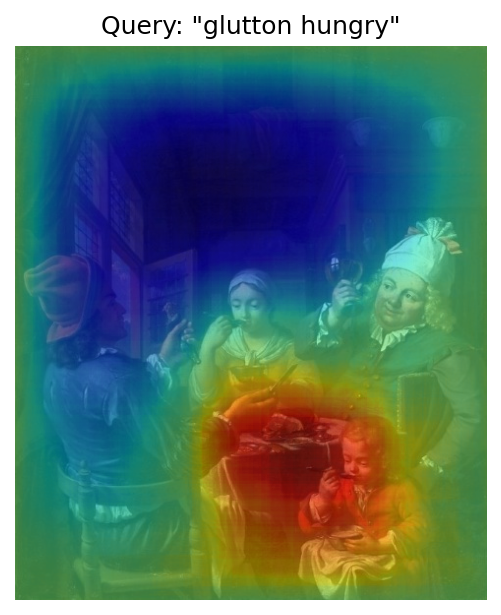

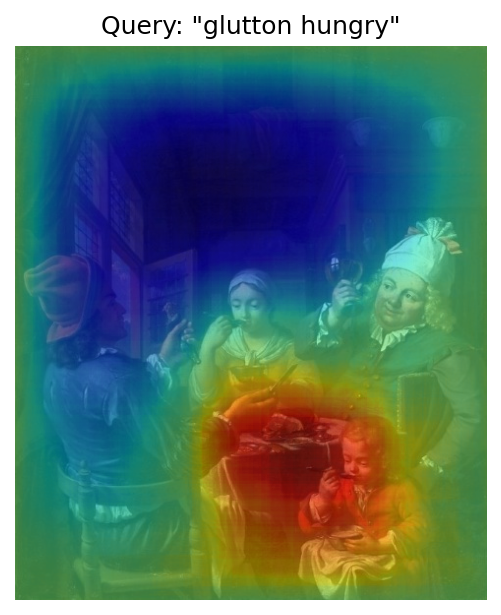

In [ ]:
inputs = processor(text=[sample_context], images=[im_tensor], return_tensors="pt").to(device)
with torch.no_grad():
    results = model(**inputs)

initial_similarity = cosine_similarity(results.text_embeds.cpu(), results.image_embeds.cpu()).item()  # 1. Computing query and image similarity
saliency_map = np.zeros((y_dim, x_dim))

for _ in tqdm.notebook.tqdm(range(n_iters)):  # 6. Setting number of the procedure iterations
    x, y, crop_size = get_random_crop_params(y_dim, x_dim, min_crop_size)
    im_crop = get_cropped_image(im_tensor, x, y, crop_size)  # 2. Getting a random crop of the image

    inputs = processor(text=[sample_context], images=[im_crop], return_tensors="pt").to(device)
    with torch.no_grad():
        results = model(**inputs)  # 3. Computing crop and query similarity

    similarity = cosine_similarity(results.text_embeds.cpu(), results.image_embeds.cpu()).item() - initial_similarity  # 4. Subtracting query and image similarity from crop and query similarity
    update_saliency_map(saliency_map, similarity, x, y, crop_size)  # 5. Updating the region on the saliency map

plot_saliency_map(im_tensor, saliency_map, sample_context)

## Image segmentation
Visualize segmentation results from CLIPSeg.

In [ ]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
import matplotlib.pyplot as plt
import matplotlib.patches as patches

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined").to(device).eval()

In [ ]:
def plot_segmented_images(preds, sample_label, sample_context):
  # Change the figsize to adjust the overall figure size
  _, ax = plt.subplots(1, 10, figsize=(20, 4))

  [a.axis('off') for a in ax.flatten()]

  # Adjust the display size of each image
  display_size = (300, 300)  # You can change the size as needed

  # Modify the code to use imshow with extent and add a red border around the selected image
  for i in range(10):
      image = torch.sigmoid(preds[i][0])
      extent = [0, display_size[0], 0, display_size[1]]

      # Check if the current index is the sample_label
      if i == sample_label:
          ax[i].imshow(image, extent=extent)  # You can change the cmap as needed
          ax[i].add_patch(plt.Rectangle((0, 0), display_size[0], display_size[1], linewidth=2, edgecolor='red', facecolor='none'))
      else:
          ax[i].imshow(image, extent=extent)

      # Add text description at the bottom center
      ax[i].text(display_size[0] / 2, -45, str(i), ha='center', va='bottom')

  # Add a single text at the top center of the whole plot
  plt.suptitle(f'Query: "{sample_context}"', x=0.5, y=0.75, ha='center', fontsize=16)

  plt.show()

Text(0.5, 1.0, 'Query: madeira river')

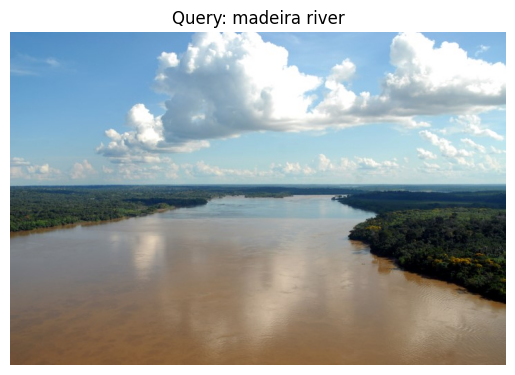

In [ ]:
sample_number = 85
sample_images = load_images(parsed_input['candidate_images'][sample_number])
sample_context = parsed_input['context'][sample_number]
sample_word = parsed_input['candidate_word'][sample_number]
sample_label = indexed_labels[sample_number]
correct_image = sample_images[sample_label]

plt.imshow(correct_image)
plt.axis('off')
plt.title(f'Query: {sample_context}')

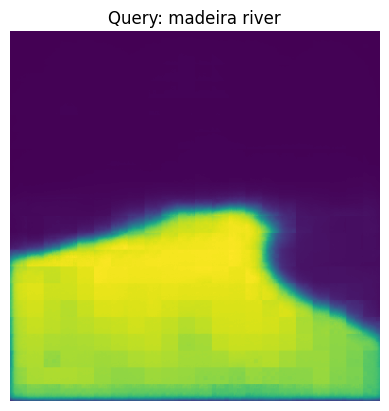

In [ ]:
with torch.no_grad():
  model_input = processor(text=[sample_context], images=[correct_image], return_tensors='pt').to(device)
  outputs = model(**model_input)
  preds = outputs.logits.cpu()

image = torch.sigmoid(preds)
plt.imshow(image)
plt.axis('off')
plt.title(f'Query: {sample_context}')
plt.show()